# `Setup`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime as dt
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch import nn
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


### `Config`

In [2]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `Data Import`

In [41]:
# IMG Transformations
transforms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImageTensor(),
    v2.ToDtype(torch.float32, scale=True)])


transforms_v2 = v2.Compose([
    #T.Grayscale(num_output_channels=1),
    v2.RandomResizedCrop(size=(224, 224), antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)
    ])


# val_transforms = T.Compose([
#     T.ToPILImage(),
#     T.Resize((224, 224), antialias=True),
#     v2.ToImageTensor(),
#     v2.ToDtype(torch.float32, scale=True)])


# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))
# target_transform = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(int(y.replace('c', ''))), value=1))

In [42]:
# Creating the dataset
train_data = StateFarmDataset(config, transform=transforms_v2, split='train', target_transform=target_transform)
print(f'Lenght of train data: {len(train_data)}')
val_data = StateFarmDataset(config, split='test', transform=transforms_v2, target_transform=target_transform)
print(f'Lenght of val data: {len(val_data)}')

Lenght of train data: 18070
Lenght of val data: 4354


In [43]:
train_data.img_labels   = train_data.img_labels.sample(10000)

In [44]:
train_data.metadata.target.value_counts(True)

safe driving                    0.108135
texting - left                  0.104815
talking on the phone - right    0.103985
talking on the phone - left     0.103486
drinking                        0.102656
operating the radio             0.102380
texting - right                 0.101051
talking to passenger            0.097399
reaching behind                 0.088268
hair and makeup                 0.087825
Name: target, dtype: float64

In [45]:
val_data.img_labels = val_data.img_labels.sample(2000)
val_data.img_labels.classname.value_counts(True)

c6    0.1180
c0    0.1170
c3    0.1135
c2    0.1020
c4    0.1015
c5    0.0990
c1    0.0985
c7    0.0945
c9    0.0800
c8    0.0760
Name: classname, dtype: float64

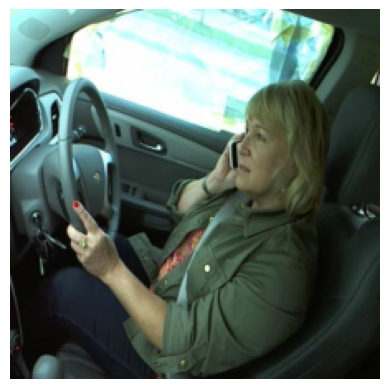

In [46]:
img, _ = train_data[100]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

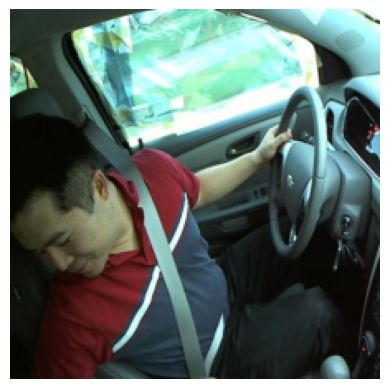

In [49]:
img, _ = val_data[100]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

## `VGG11`
Building VGG-11 Architecture. Architecture can be found [here](https://jaketae.github.io/study/pytorch-vgg/)

In [50]:
class VGG11(torch.nn.Module):
    def __init__(self, filters = 64, num_classes = 10, kernel_size = (3,3), stride = 1, in_channels = 3, pool_kernel_size = (2,2)):
        """VGG 11 Model"""
        super(VGG11, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=filters,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=filters,
                      out_channels=filters*2,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=filters*2,
                      out_channels=filters*4,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters*4,
                      out_channels=filters*4,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=filters*4,
                      out_channels=filters*8,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters*8,
                      out_channels=filters*8,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=filters*8,
                      out_channels=filters*8,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=filters*8,
                      out_channels=filters*8,
                      kernel_size=kernel_size,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2))
        
        
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=num_classes))


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = self.linear(x)
        return out

In [51]:
# Instantiating the model
model = VGG11(in_channels=3)

model

VGG11(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Ma

In [52]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [53]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGG11                                    [32, 10]                  --
├─Sequential: 1-1                        [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        128
│    └─ReLU: 2-3                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 64, 112, 112]        --
├─Sequential: 1-2                        [32, 128, 56, 56]         --
│    └─Conv2d: 2-5                       [32, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 112, 112]       256
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-8                    [32, 128, 56, 56]         --
├─Sequential: 1-3                        [32, 256, 28, 28]         --
│    └─Conv2d: 2-9                       [32, 256, 56, 56]         295,168
│

In [62]:
t = model(x)

In [72]:
(t.argmax(dim=1) == y).float().mean()

tensor(0.0938)

#### `Training Methods`

In [54]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [74]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [75]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [76]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Loop through epochs
    for epoch in range(epochs):
        print(f'Epoch {epoch+1} started...')
        
        # Set model to train mode and do pass over data
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)

        # lr Scheduler step
        scheduler.step(val_loss)
        

        # Print info
        print(f"Epoch {epoch+1} of {epochs} - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Model name
            timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
            name = f'VGG11_{timestamp}_{epoch+1}.pt'
            
            # Save model
            try:
                torch.save(model.state_dict(), config['outputs']['path'] + '/VGG11/' + name)
            except:
                os.mkdir(config['outputs']['path'] + '/VGG11/')
                torch.save(model.state_dict(), config['outputs']['path'] + '/VGG11/' + name)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

Epoch 1 started...
Epoch 1 of 50 - Train loss: 1.83352 - Train acc: 0.33996 - Val loss: 1.66340 - Val acc: 0.36111
Saving model with new best val_loss: 1.66340
Epoch 2 started...
Epoch 2 of 50 - Train loss: 0.65783 - Train acc: 0.78045 - Val loss: 1.39503 - Val acc: 0.55357
Saving model with new best val_loss: 1.39503
Epoch 3 started...
Epoch 3 of 50 - Train loss: 0.30715 - Train acc: 0.90096 - Val loss: 1.20159 - Val acc: 0.64484
Saving model with new best val_loss: 1.20159
Epoch 4 started...
Epoch 4 of 50 - Train loss: 0.18700 - Train acc: 0.93810 - Val loss: 1.15233 - Val acc: 0.68948
Saving model with new best val_loss: 1.15233
Epoch 5 started...
Epoch 5 of 50 - Train loss: 0.13933 - Train acc: 0.95647 - Val loss: 2.14395 - Val acc: 0.48363


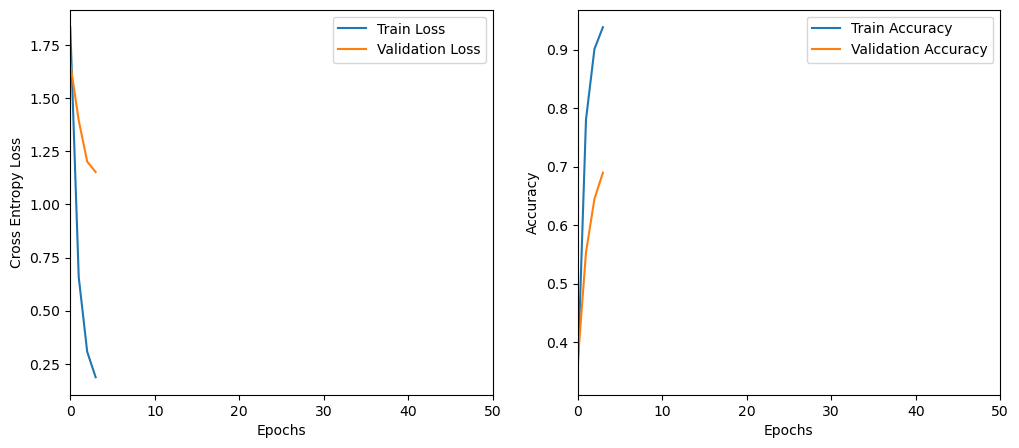

Epoch 6 started...
Epoch 6 of 50 - Train loss: 0.10199 - Train acc: 0.96935 - Val loss: 1.56357 - Val acc: 0.62798
Epoch 7 started...
Epoch 7 of 50 - Train loss: 0.08153 - Train acc: 0.97304 - Val loss: 1.41266 - Val acc: 0.65079
Epoch 8 started...
Epoch 8 of 50 - Train loss: 0.06543 - Train acc: 0.97784 - Val loss: 1.36064 - Val acc: 0.69196
Epoch 9 started...
Epoch 9 of 50 - Train loss: 0.05567 - Train acc: 0.98163 - Val loss: 1.58271 - Val acc: 0.66716
Epoch 10 started...
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10 of 50 - Train loss: 0.05939 - Train acc: 0.98063 - Val loss: 1.66071 - Val acc: 0.64633


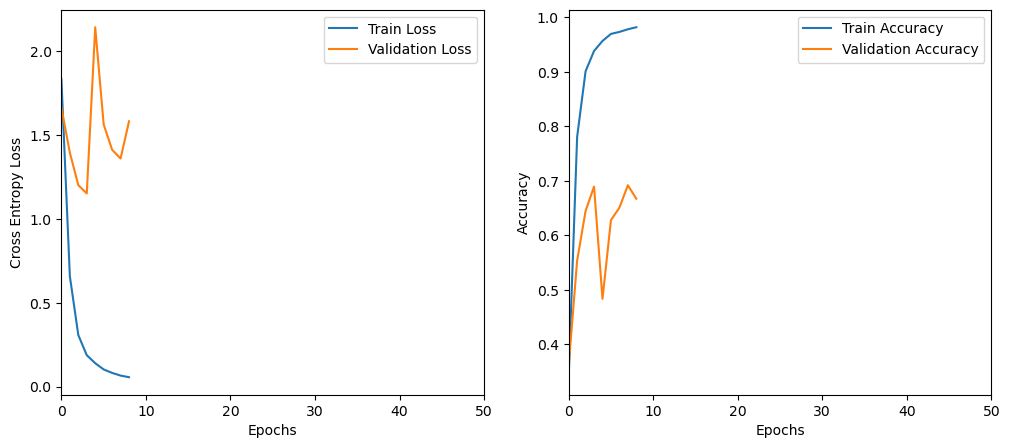

Epoch 11 started...
Epoch 11 of 50 - Train loss: 0.02273 - Train acc: 0.99311 - Val loss: 1.45099 - Val acc: 0.67609
Epoch 12 started...
Epoch 12 of 50 - Train loss: 0.01543 - Train acc: 0.99531 - Val loss: 1.40025 - Val acc: 0.69395
Epoch 13 started...
Epoch 13 of 50 - Train loss: 0.01182 - Train acc: 0.99681 - Val loss: 1.35148 - Val acc: 0.69990
Epoch 14 started...
Epoch 14 of 50 - Train loss: 0.01086 - Train acc: 0.99681 - Val loss: 1.30756 - Val acc: 0.71081
Epoch 15 started...
Epoch 15 of 50 - Train loss: 0.00887 - Train acc: 0.99800 - Val loss: 1.35984 - Val acc: 0.70734


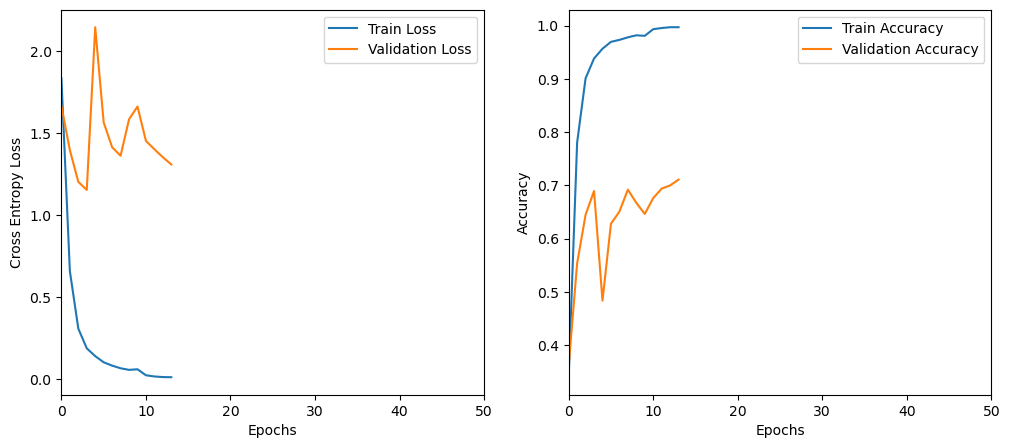

Epoch 16 started...
Epoch 00016: reducing learning rate of group 0 to 1.0000e-05.
Epoch 16 of 50 - Train loss: 0.00859 - Train acc: 0.99750 - Val loss: 1.37873 - Val acc: 0.69990
Epoch 17 started...
Epoch 17 of 50 - Train loss: 0.00901 - Train acc: 0.99700 - Val loss: 1.33525 - Val acc: 0.70387
Epoch 18 started...
Epoch 18 of 50 - Train loss: 0.00939 - Train acc: 0.99750 - Val loss: 1.35145 - Val acc: 0.71181
Epoch 19 started...
Epoch 19 of 50 - Train loss: 0.00755 - Train acc: 0.99780 - Val loss: 1.35746 - Val acc: 0.71181
Epoch 20 started...
Epoch 20 of 50 - Train loss: 0.00646 - Train acc: 0.99890 - Val loss: 1.41456 - Val acc: 0.70833


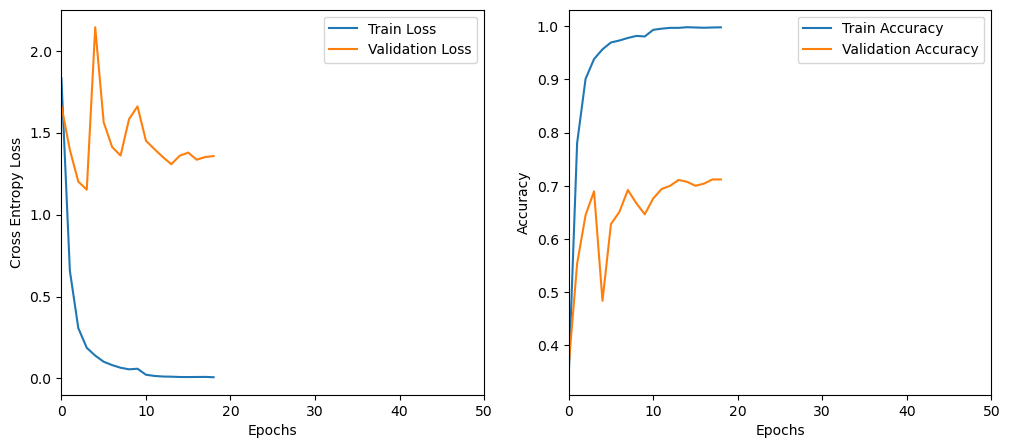

Epoch 21 started...
Epoch 21 of 50 - Train loss: 0.00747 - Train acc: 0.99780 - Val loss: 1.35332 - Val acc: 0.70883
Epoch 22 started...
Epoch 00022: reducing learning rate of group 0 to 1.0000e-06.
Epoch 22 of 50 - Train loss: 0.00759 - Train acc: 0.99770 - Val loss: 1.38322 - Val acc: 0.70585
Epoch 23 started...
Epoch 23 of 50 - Train loss: 0.00752 - Train acc: 0.99790 - Val loss: 1.37207 - Val acc: 0.70040
Epoch 24 started...
Epoch 24 of 50 - Train loss: 0.00640 - Train acc: 0.99880 - Val loss: 1.33962 - Val acc: 0.70685
Epoch 25 started...
Epoch 25 of 50 - Train loss: 0.00747 - Train acc: 0.99860 - Val loss: 1.32940 - Val acc: 0.70933


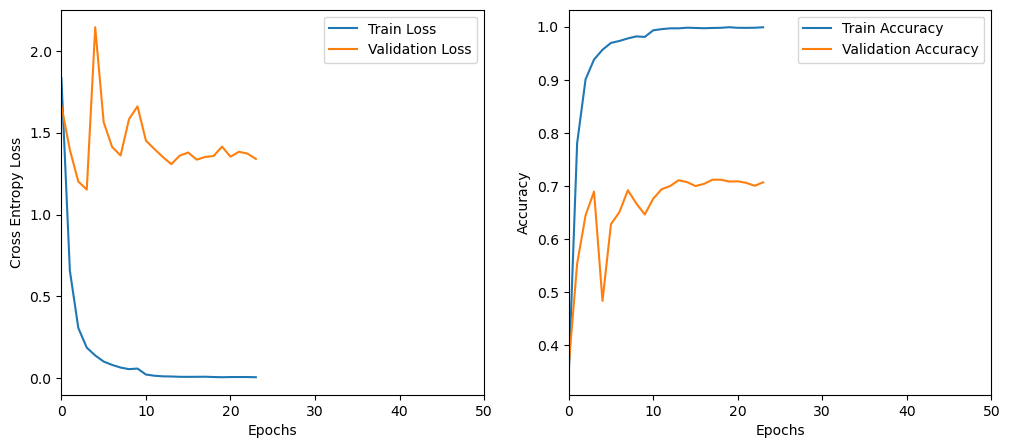

Epoch 26 started...
Epoch 26 of 50 - Train loss: 0.00667 - Train acc: 0.99900 - Val loss: 1.32241 - Val acc: 0.70486
Epoch 27 started...
Epoch 27 of 50 - Train loss: 0.00733 - Train acc: 0.99780 - Val loss: 1.40895 - Val acc: 0.70288
Epoch 28 started...
Epoch 00028: reducing learning rate of group 0 to 1.0000e-07.
Epoch 28 of 50 - Train loss: 0.00767 - Train acc: 0.99820 - Val loss: 1.36754 - Val acc: 0.70536
Epoch 29 started...
Epoch 29 of 50 - Train loss: 0.00714 - Train acc: 0.99850 - Val loss: 1.37207 - Val acc: 0.70933
Epoch 30 started...
Epoch 30 of 50 - Train loss: 0.00650 - Train acc: 0.99840 - Val loss: 1.32849 - Val acc: 0.70883


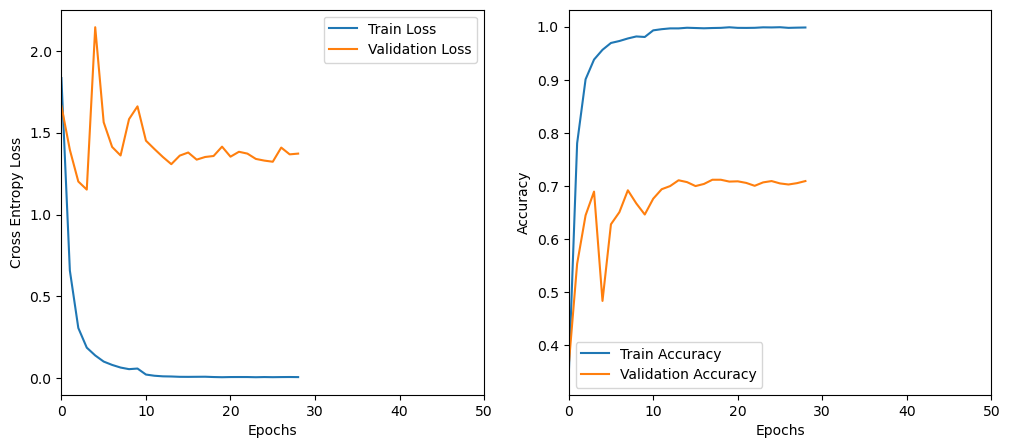

Epoch 31 started...
Epoch 31 of 50 - Train loss: 0.00688 - Train acc: 0.99830 - Val loss: 1.35338 - Val acc: 0.70982
Epoch 32 started...
Epoch 32 of 50 - Train loss: 0.00849 - Train acc: 0.99720 - Val loss: 1.37924 - Val acc: 0.70337
Epoch 33 started...
Epoch 33 of 50 - Train loss: 0.00730 - Train acc: 0.99830 - Val loss: 1.35322 - Val acc: 0.70734
Epoch 34 started...
Epoch 34 of 50 - Train loss: 0.00851 - Train acc: 0.99740 - Val loss: 1.36461 - Val acc: 0.70337
Epoch 35 started...
Epoch 35 of 50 - Train loss: 0.00670 - Train acc: 0.99900 - Val loss: 1.36784 - Val acc: 0.70833


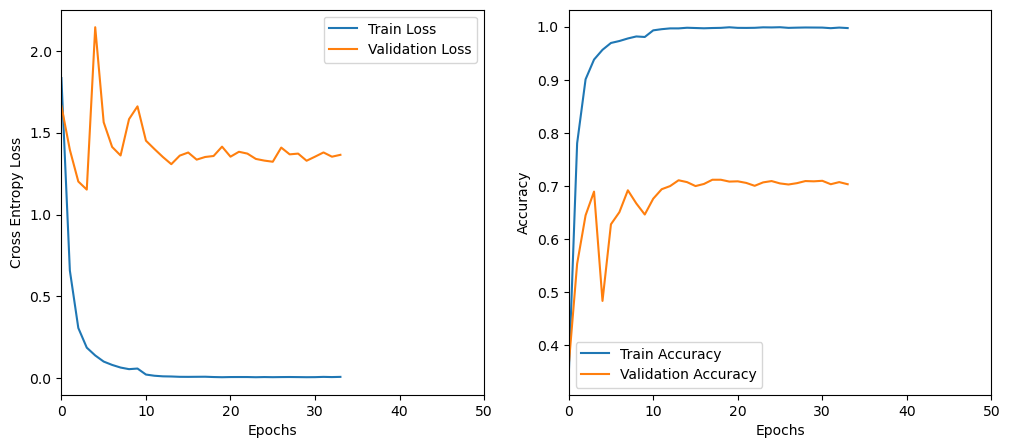

Epoch 36 started...
Epoch 36 of 50 - Train loss: 0.00688 - Train acc: 0.99830 - Val loss: 1.37648 - Val acc: 0.70486
Epoch 37 started...
Epoch 37 of 50 - Train loss: 0.00746 - Train acc: 0.99810 - Val loss: 1.38403 - Val acc: 0.70734
Epoch 38 started...
Epoch 38 of 50 - Train loss: 0.00804 - Train acc: 0.99800 - Val loss: 1.36425 - Val acc: 0.70784
Epoch 39 started...
Epoch 39 of 50 - Train loss: 0.00598 - Train acc: 0.99880 - Val loss: 1.39204 - Val acc: 0.69692
Epoch 40 started...
Epoch 40 of 50 - Train loss: 0.00669 - Train acc: 0.99860 - Val loss: 1.37237 - Val acc: 0.70784


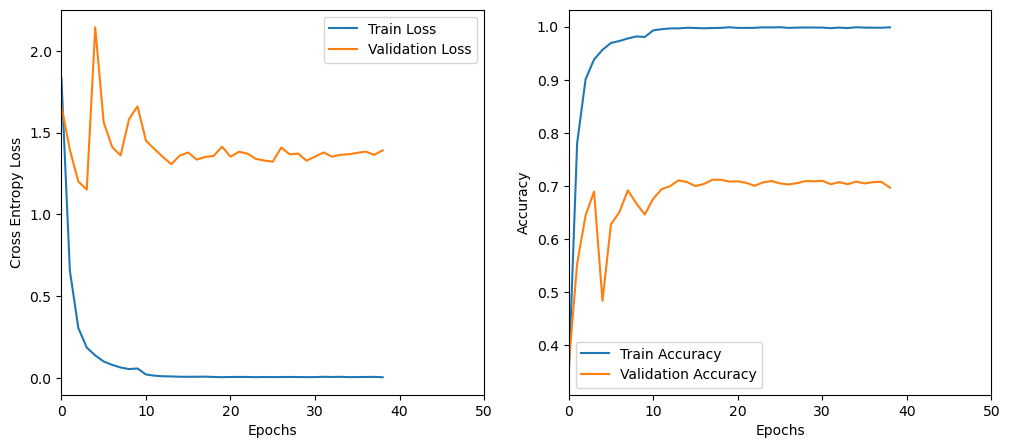

Epoch 41 started...
Epoch 41 of 50 - Train loss: 0.00729 - Train acc: 0.99850 - Val loss: 1.35263 - Val acc: 0.70685
Epoch 42 started...
Epoch 42 of 50 - Train loss: 0.00631 - Train acc: 0.99840 - Val loss: 1.37289 - Val acc: 0.70387
Epoch 43 started...
Epoch 43 of 50 - Train loss: 0.00839 - Train acc: 0.99770 - Val loss: 1.37759 - Val acc: 0.69792
Epoch 44 started...
Epoch 44 of 50 - Train loss: 0.00741 - Train acc: 0.99830 - Val loss: 1.35567 - Val acc: 0.70089
Epoch 45 started...
Epoch 45 of 50 - Train loss: 0.00615 - Train acc: 0.99870 - Val loss: 1.37250 - Val acc: 0.71081


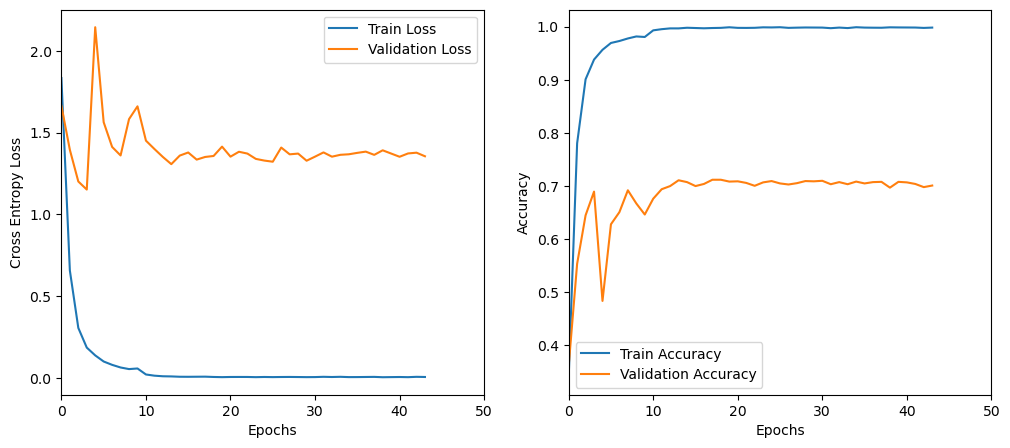

Epoch 46 started...
Epoch 46 of 50 - Train loss: 0.00606 - Train acc: 0.99870 - Val loss: 1.37044 - Val acc: 0.70238
Epoch 47 started...
Epoch 47 of 50 - Train loss: 0.00638 - Train acc: 0.99860 - Val loss: 1.34808 - Val acc: 0.70933
Epoch 48 started...
Epoch 48 of 50 - Train loss: 0.00812 - Train acc: 0.99740 - Val loss: 1.37254 - Val acc: 0.71081
Epoch 49 started...
Epoch 49 of 50 - Train loss: 0.00763 - Train acc: 0.99830 - Val loss: 1.37038 - Val acc: 0.70238
Epoch 50 started...
Epoch 50 of 50 - Train loss: 0.00671 - Train acc: 0.99880 - Val loss: 1.37622 - Val acc: 0.70139


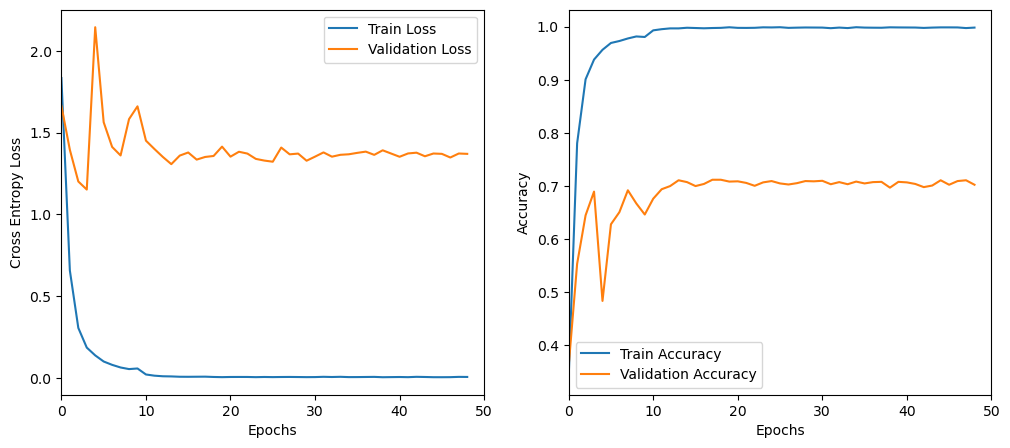

In [78]:
# Set random seeds
torch.manual_seed(42)


# Recreate an instance of TinyVGG
model = VGG11(in_channels=3).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model.parameters(),
#                              lr=0.01, 
#                              weight_decay=1e-5,
#                              eps=1e-06)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min',
                                                       factor=.1,
                                                       patience=5,
                                                       min_lr=1e-7,
                                                       verbose=True)

# Train model_0
model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        validation_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs,
                        device=device,
                        scheduler=scheduler)

### Random Predictions on Validation Data

In [182]:
# Visualize training
import random

# Get random batch of images
imgs, labels = next(iter(test_dataloader), random.randint(0, len(test_dataloader)))

model.eval()

# Make predictions
predictions = model(imgs.to(device)).argmax(1)

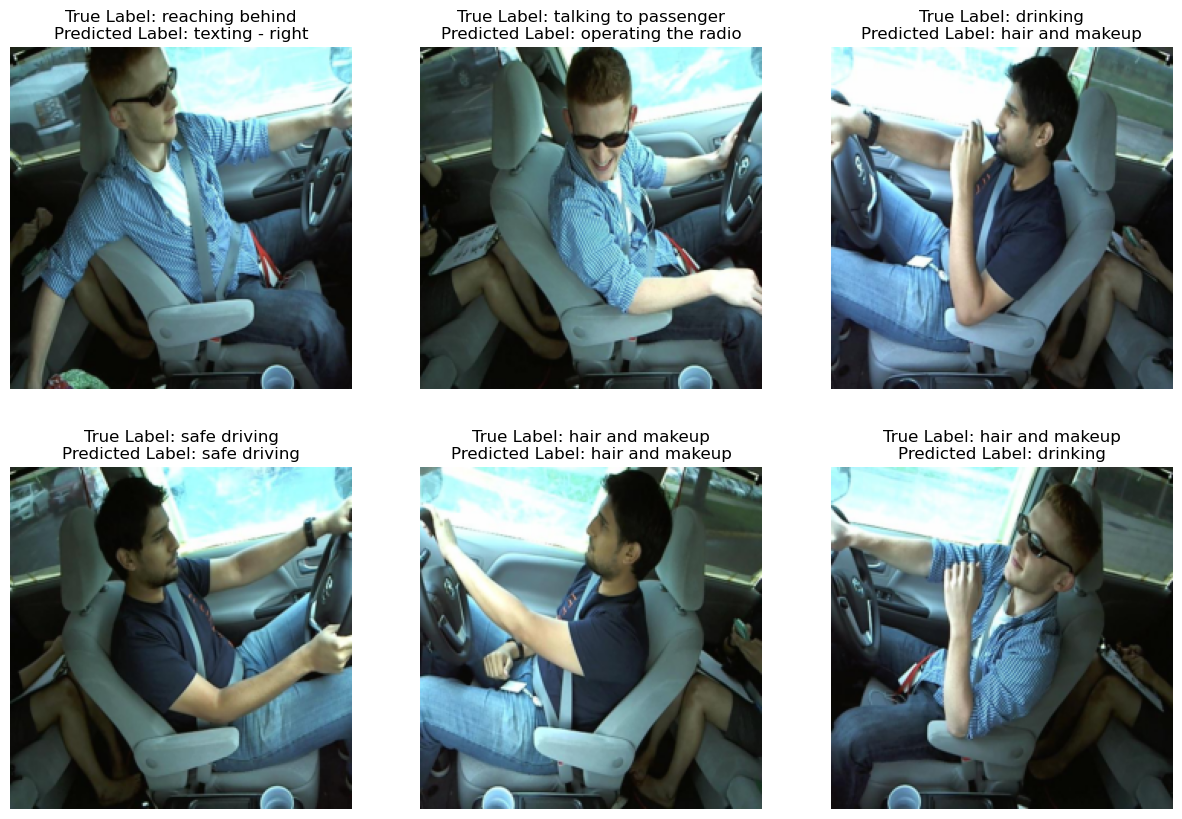

In [183]:
# Plot images with labels and predictions
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop through images
for ax in axs.flatten():
    i = random.randint(0, len(imgs)-1)
    ax.imshow(imgs[i].permute(1, 2, 0))
    ax.set_title(f"True Label: {config['dataset']['class_mapping']['c' + str(labels[i].item())]}\nPredicted Label: {config['dataset']['class_mapping']['c' + str(predictions[i].item())]}")
    ax.axis('off')
